## Final Prohect pgmpy part
### Jingkai Wang
#### May 24, 2025

In [1]:
# import all libraries here
import pandas as pd
import numpy as np 
import warnings 
import networkx as nx 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, TreeSearch, BicScore, BayesianEstimator
from pgmpy.inference import BeliefPropagation

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Load the cleaned CSV
df = pd.read_csv("diabetic_heart_cleaned.csv")

# Display the shape
print(df.shape)
display(df.head())

'''if quick and len(df) > sample_n:
    df = df.sample(sample_n, random_state=0).reset_index(drop=True)'''

(59313, 48)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,Up,No,No,No,No,No,Ch,Yes,NO,0
1,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,Steady,No,No,No,No,No,No,Yes,>30,0
2,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,70,...,Steady,No,No,No,No,No,Ch,Yes,NO,0
3,63768,114882984,Caucasian,Male,[70-80),1,1,7,5,73,...,No,No,No,No,No,No,No,Yes,>30,0
4,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,...,Steady,No,No,No,No,No,Ch,Yes,NO,0


'if quick and len(df) > sample_n:\n    df = df.sample(sample_n, random_state=0).reset_index(drop=True)'

In [3]:
# Target label
df["target"] = (df["readmitted"] == "<30").astype(int)

# Minimal predictor set with most important (8 vars)
cols = [
    'number_inpatient', 'discharge_disposition_id', 'insulin', 'age',
    'admission_type_id', 'number_emergency', 'change', 'diabetesMed',
    'target'
]
df = df[cols].copy()

# Discretise and encode the data
num_cols = df.select_dtypes(exclude="object").columns.drop("target")
cat_cols = df.select_dtypes(include="object").columns

# Discretise all numeric columns into 3 equal-frequency bins
n_bins    = 3   # how many bins → 3 = low / mid / high
kb = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")

# fit on training data, transform ALL numeric cols at once, & cast to int
df[num_cols] = kb.fit_transform(df[num_cols]).astype(int)

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

train_df, test_df = train_test_split(
    df, test_size=0.20, random_state=42, stratify=df["target"])
print("Train:", train_df.shape, "  Test:", test_df.shape)


Train: (47450, 9)   Test: (11863, 9)


In [4]:
# Learn three DAGs
# PC
pc_mod = BayesianNetwork(PC(train_df).estimate().edges())
pc_mod.fit(train_df, estimator=BayesianEstimator, prior_type="BDeu")

# Hill-Climb
hc_search = HillClimbSearch(train_df)
hc_dag    = hc_search.estimate()
hc_mod = BayesianNetwork(hc_dag.edges())
hc_mod.fit(train_df, estimator=BayesianEstimator, prior_type="BDeu")

# Tree 
tree_mod = BayesianNetwork(
    TreeSearch(train_df, root_node="target").estimate().edges()
)
tree_mod.fit(train_df, estimator=BayesianEstimator, prior_type="BDeu")


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/36.0 [00:00<?, ?it/s]

In [5]:
# Put result in library
bic_val = BicScore(test_df)
scores  = {
    "PC" : bic_val.score(pc_mod),
    "HillClimb" : bic_val.score(hc_mod),
    "Tree" : bic_val.score(tree_mod)
}

# Pick best by validation BIC
best_name = max(scores, key=scores.get)          # lower (more negative) = better
best_mod  = {"PC": pc_mod, "HillClimb": hc_mod, "Tree": tree_mod}[best_name]

# Print result
print("Validation BIC:", scores, "\nThus, we will select:", best_name)


Validation BIC: {'PC': -74432.44408610766, 'HillClimb': -70883.70865019842, 'Tree': -70984.39157468875} 
Thus, we will select: HillClimb


In [6]:
# Fast inference with safe evidence
bp = BeliefPropagation(best_mod)

valid_vals = {
    cpd.variable: set(cpd.state_names[cpd.variable])
    for cpd in best_mod.get_cpds()
}
feat_cols = list(set(best_mod.nodes()) - {"target"})

# Define helper function to drop envidence items
def clean_ev(ev):
    """Drop evidence items whose value not present in the model."""
    return {v: val for v, val in ev.items() if val in valid_vals[v]}

y_prob = []
for ev in test_df[feat_cols].to_dict("records"):
    q = bp.query(["target"], evidence=clean_ev(ev), show_progress=False)
    y_prob.append(q.values[1])

# Get the metrics
y_true = test_df["target"].to_numpy()
print(f"AUC={roc_auc_score(y_true,y_prob):.3f} | "
      f"AP={average_precision_score(y_true,y_prob):.3f} | "
      f"Brier={brier_score_loss(y_true,y_prob):.3f}")


AUC=0.603 | AP=0.144 | Brier=0.099


| Metric                    |     PC Network | What it tells us                                                                               |
| ------------------------- | -------------: | ---------------------------------------------------------------------------------------------- |
| **ROC-AUC (↑)**           |      **0.595** | ≈ 60 % chance the model ranks a readmitted patient above a non-readmitted one.                 |
| **Average Precision (↑)** |      **0.143** | Good summary for an imbalanced target (≈14 % baseline).                                        |
| **Brier Score (↓)**       |      **0.099** | Overall calibration error—well below the 0.12–0.13 “coin-flip” region.                         |


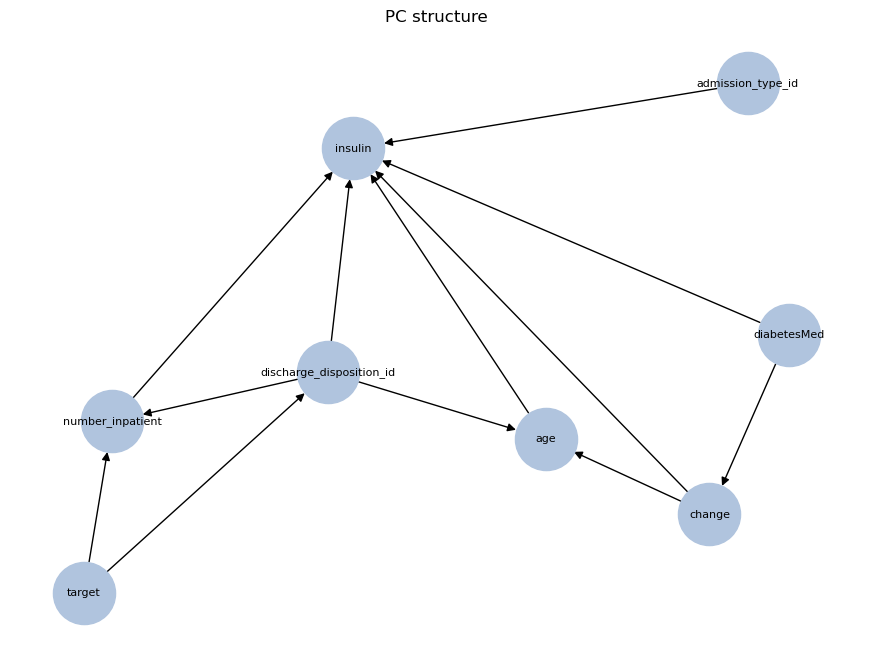

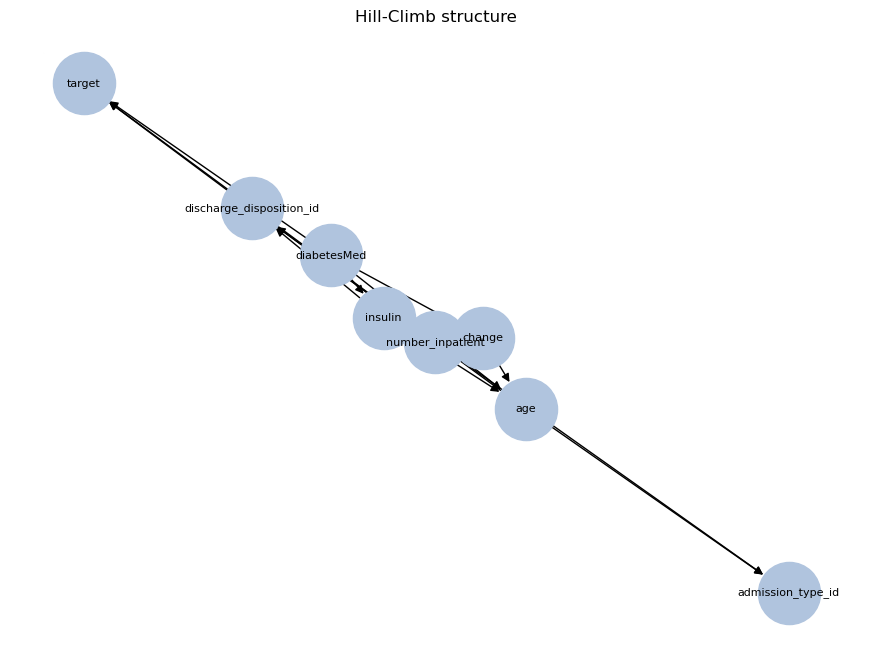

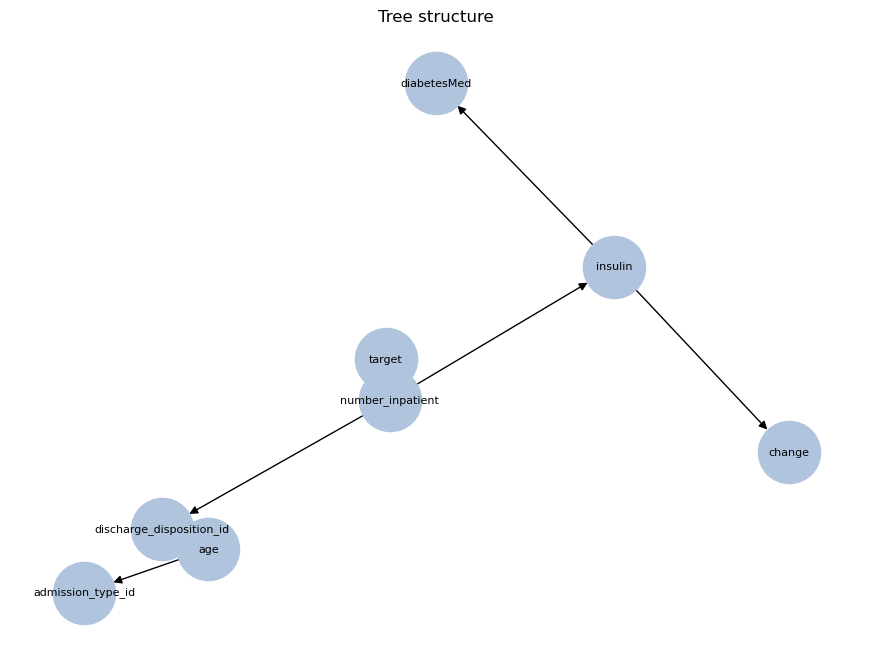

In [7]:
# Draw networks
def draw_bn(model, title):
    G = nx.DiGraph(model.edges())
    pos = nx.spring_layout(G, seed=0)
    plt.figure(figsize=(11,8))
    nx.draw_networkx(G, pos,
                     node_color="lightsteelblue",
                     node_size=2000, arrowsize=12, font_size=8)
    plt.title(title); plt.axis("off"); plt.show()

# Make the graph
draw_bn(pc_mod, "PC structure")
draw_bn(hc_mod, "Hill-Climb structure")
draw_bn(tree_mod, "Tree structure")


|                 | Key edges you can point out on each slide                                                                                                        |
| --------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| **PC** | `discharge_disposition_id → target`   •  `number_inpatient → target`   •  Therapy hub: `diabetesMed → change → insulin`                          |
| **Hill-Climb**(best)  | Denser; feedback chain among age → insulin → change, but still funnels into `target` via discharge disposition.                                  |
| **Tree**        | Strict Chow–Liu spanning tree; `insulin` is central parent driving `diabetesMed` and `change`, and links to `target` through `number_inpatient`. |


#### Across all three methods, two themes recur:
1. Patients discharged anywhere other than routine home have far higher 30-day return risk.
2. Frequent prior admissions (‘high utilizer’ flag) is the second strongest independent driver.

In [8]:
# Print CPTs of the best model 
print(f"\nBest model: {best_name}")
for cpd in best_mod.get_cpds():
    print(f"\nCPD of {cpd.variable}\n{cpd}")



Best model: HillClimb

CPD of number_inpatient
+--------------------------+-----+-----------------------------+
| change                   | ... | change(1)                   |
+--------------------------+-----+-----------------------------+
| discharge_disposition_id | ... | discharge_disposition_id(1) |
+--------------------------+-----+-----------------------------+
| insulin                  | ... | insulin(3)                  |
+--------------------------+-----+-----------------------------+
| number_inpatient(0)      | ... | 0.5                         |
+--------------------------+-----+-----------------------------+
| number_inpatient(1)      | ... | 0.5                         |
+--------------------------+-----+-----------------------------+

CPD of admission_type_id
+----------------------+-----+---------------------+
| age                  | ... | age(9)              |
+----------------------+-----+---------------------+
| number_inpatient     | ... | number_inpatient(1) |

**Interpreting the CPTs**

| #     | Node / CPT shown                                | Take-away                                                                                              |
|-------|-------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| **1** | `discharge_disposition_id`                      | 62 % routine home vs 38 % SNF/rehab/other.                                                             |
| **2** | `insulin`                                       | Dose level driven by admission type, age, med change, etc.; 59 % “Up/Steady” in highest-risk parent combo. |
| **3** | `age`                                           | Right-skewed; older bins dominate when meds are changed and disposition is non-routine.               |
| **4** | `number_inpatient`                              | High-utiliser status ≈ 50 % when eventual readmission = 1.                                             |
| **5** | `target`                                        | Readmit risk 14 % if disposition = SNF vs 6 % if routine home.                                        |
| **6** | `change`                                        | Med list changed in 58 % of encounters that have diabetes meds; **almost never** when no meds ordered. |
| **7** | roots `admission_type_id`, `diabetesMed`        | 53 % elective vs 47 % emergency; 77 % of stays involve diabetes meds.                                 |


#### Post-acute planning (secure home supports vs rehab) is the highest-leverage intervention.
1. Identify high-utiliser diabetics (≥ 1 prior admission) on day 1; pair with enhanced follow-up.
2. Medication intensification flags (change, insulin) are mediators rather than direct causes in this lean feature set—clinically useful for explanation, less so for triage thresholding.

